<a href="https://colab.research.google.com/github/juyongkak/MLproject/blob/main/Y_NetCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Y - Network

Y - Network 는 동일한 입력을 CNN 의 왼쪽과 오른쪽 가지에 두번 사용한다. 
신경망은 concatenate 계층을 사용하여 결과를 결합한다. 
결합 연산인 concate 연결축을 따라 동일한 형상을 갖는 두개의 텐서를 연결해 하나의 텐서를 구성하는 것과 비슷하다. 

우선 Y - Network 의 가지에서 필터수를 두배로 늘려 MaxPooling2D() 층 다음에서 특징 맵 크기가 절반으로 줄어든 것을 보완한다.
또, 양쪽 가지의 커널 크기는 3으로 같지만 오른쪽 가지에서는 팽창률을 2로 적용한다. 크기가 3인 커널에 팽창률을 사용해 커널의 적용 범위를 
증가 시키면, 이 CNN 모델에서 오른쪽 가지가 다양한 특징 맵을 학습시킬 수 있다는 것이다.

여기에서 padding = 'same' 옵션을 사용해 팽창된 CNN을 사용할 때 텐서 차원이 음수가 되지 않게 만든다.

In [1]:
import numpy as np

from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import concatenate
from tensorflow.keras.utils import plot_model

In [2]:
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


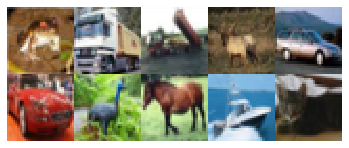

In [16]:
# Training image 10개 미리보기기
images = x_train[:10]
width = images.shape[1]
height= images.shape[2]
channel = images.shape[3]
if channel==1:
    imgs = images.reshape((2,5,width,height))
else:
    imgs = images.reshape((2,5,width,height,channel))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
if channel==1:
    plt.imshow(imgs, interpolation='none', cmap='gray')
else:
    plt.imshow(imgs, interpolation='none')

In [3]:
#레이블 수 계산
num_labels = len(np.unique(y_train))

#원-핫 벡터로 변환
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
#입력 이미지 Shape 재조정, 규격화
image_size = x_train.shape[1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [5]:
# 신경망 매개변수 입력
input_shape = (image_size,image_size,3)
batch_size =32
kernel_size = 3
n_filters = 32
dropout = 0.3

In [6]:
# Y-Network 왼쪽 가지 작성
left_inputs = Input(shape=input_shape)
filters = n_filters

x = left_inputs

#Conv2D - Dropout - MaxPoling2D 3계층 구성
#계층이 지날 떄 마다 필터 개수를 두배로 증가시킴(32 - 64 - 128)
for i in range(3):
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              padding='same',
              activation='relu')(x)
    
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    
    filters *= 2

In [7]:
#Y-Network 오른쪽 가지 작성
right_inputs = Input(shape=input_shape)
filters = n_filters

y = right_inputs

#Conv2D - Dropout - MaxPoling2D 3계층 구성
#계층이 지날 떄 마다 필터 개수를 두배로 증가시킴(32 - 64 - 128)
for i in range(3):
    y = Conv2D(filters=filters,
              kernel_size=kernel_size,
              padding='same',
              activation='relu',
              dilation_rate=2)(y)
    
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    
    filters *=2

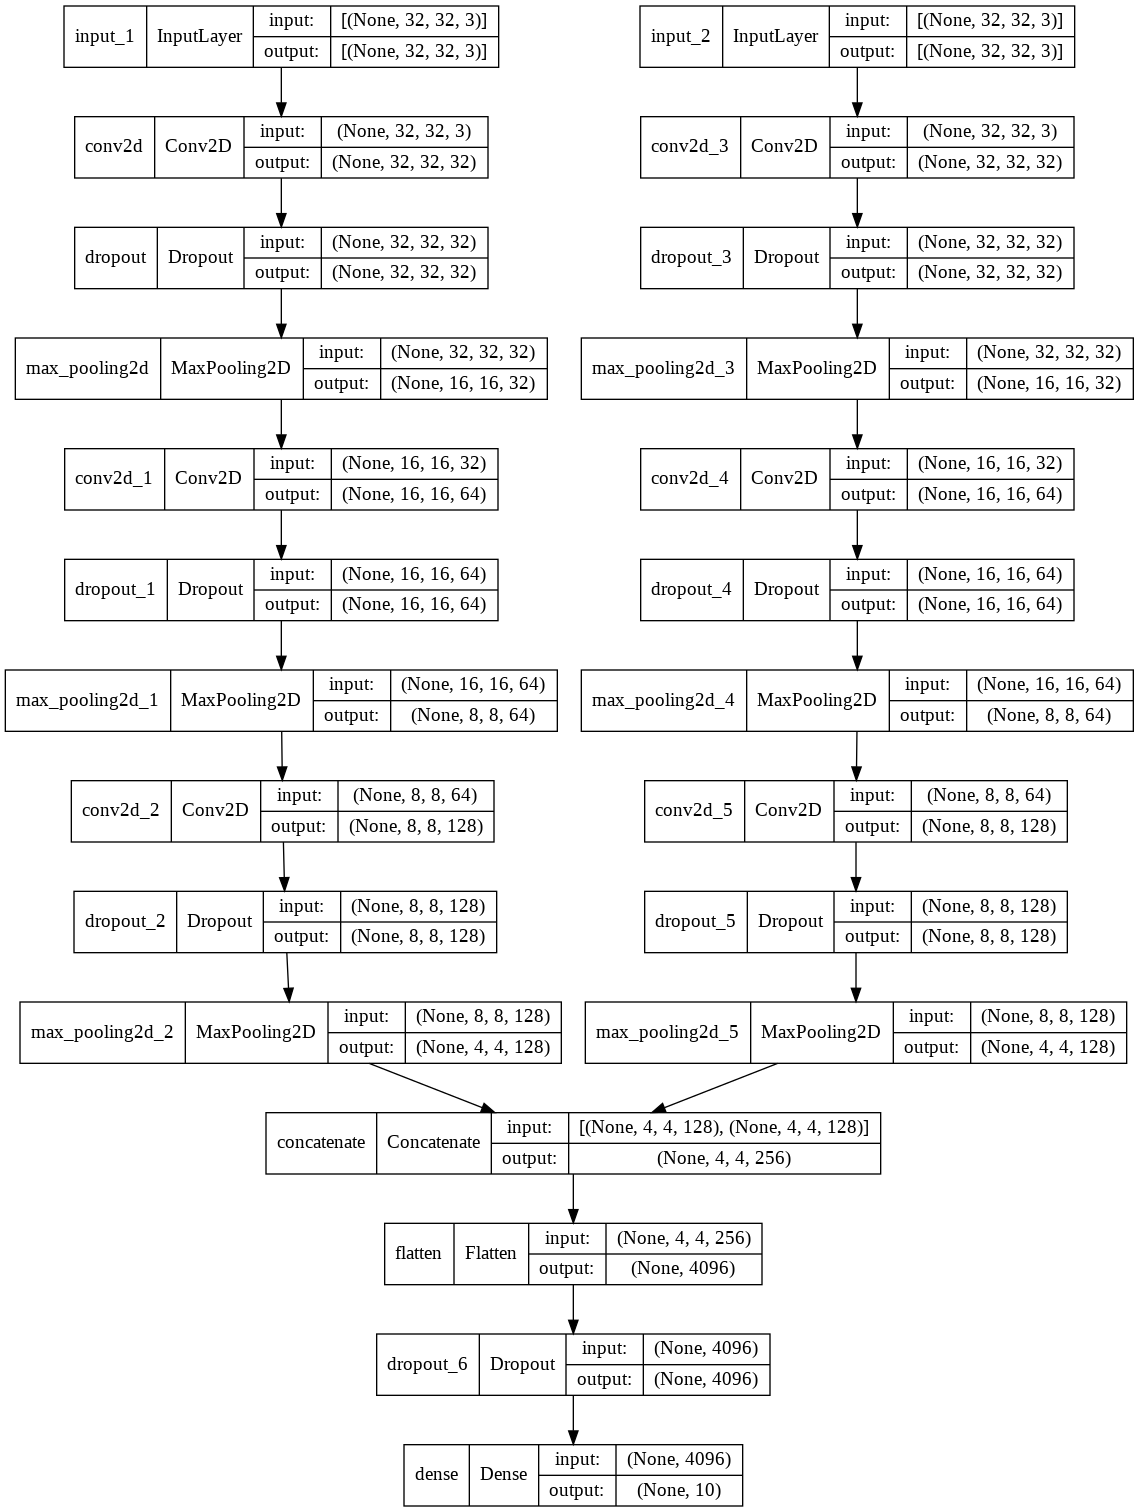

In [8]:
# Y - Network 결합
y = concatenate([x,y])

# Dense 계층에 연결하기 전 특징 맵을 벡터로 변환
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

model = Model([left_inputs, right_inputs], outputs)
plot_model(model, to_file = 'cnn-y-network.png', show_shapes=True)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                              

In [10]:
#모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
hist=model.fit([x_train, x_train], y_train, validation_data=([x_test, x_test], y_test), epochs=20, batch_size=batch_size)

Epoch 1/20
1563/1563 [==============================] - 29s 18ms/step - loss: 0.5681 - accuracy: 0.7985 - val_loss: 0.7986 - val_accuracy: 0.7296
Epoch 2/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.5618 - accuracy: 0.8031 - val_loss: 0.7771 - val_accuracy: 0.7333
Epoch 3/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.5507 - accuracy: 0.8061 - val_loss: 0.7706 - val_accuracy: 0.7311
Epoch 4/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.5469 - accuracy: 0.8076 - val_loss: 0.7841 - val_accuracy: 0.7279
Epoch 5/20
1563/1563 [==============================] - 27s 18ms/step - loss: 0.5509 - accuracy: 0.8069 - val_loss: 0.8712 - val_accuracy: 0.6957
Epoch 6/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.5388 - accuracy: 0.8097 - val_loss: 0.7194 - val_accuracy: 0.7514
Epoch 7/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.5323 - accuracy: 0.8113 - val_loss: 0.7374 -

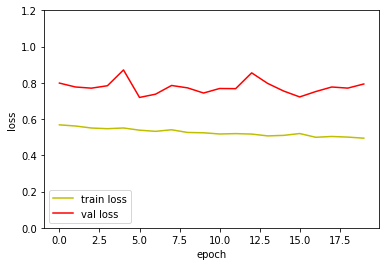

In [22]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')

# plt.ylim([0.0,1.2])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='lower left')

# plt.rcParams["figure.figsize"] = (10,8)
plt.show()

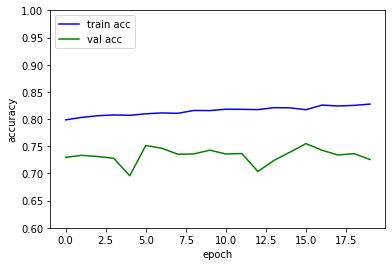

In [21]:
plt.plot(hist.history['accuracy'], 'b', label='train acc')
plt.plot(hist.history['val_accuracy'], 'g', label='val acc')

# plt.ylim([0.6,1.0])

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(loc='upper left')

# plt.rcParams["figure.figsize"] = (10,8)
plt.show()

**모델 평가**

In [24]:
loss_and_acc = model.evaluate([x_test, x_test], y_test, batch_size=32)
print('Test set Loss and Accuracy')
print(loss_and_acc)

313/313 [==============================] - 3s 9ms/step - loss: 0.7936 - accuracy: 0.7256
Test set Loss and Accuracy
[0.793647289276123, 0.725600004196167]


예측측 :고양이 / 정답답 : 고양이


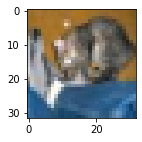

예측측 :배 / 정답답 : 배


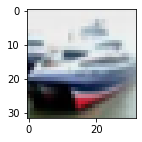

예측측 :배 / 정답답 : 배


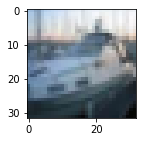

예측측 :비행기 / 정답답 : 비행기


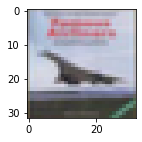

예측측 :개구리 / 정답답 : 개구리


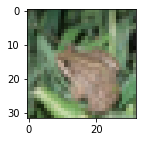

예측측 :개구리 / 정답답 : 개구리


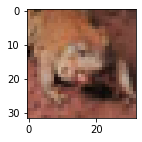

예측측 :자동차 / 정답답 : 자동차


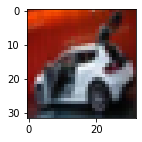

예측측 :개구리 / 정답답 : 개구리


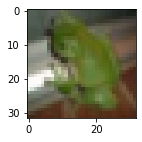

예측측 :고양이 / 정답답 : 고양이


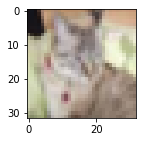

예측측 :개구리 / 정답답 : 자동차


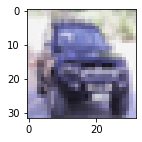

In [34]:
labels = ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']

plt.rcParams["figure.figsize"] = (2,2)

for i in range(10):
  output = model.predict([x_test[i].reshape(1,width,height,channel),x_test[i].reshape(1,width,height,channel)])
  
  plt.imshow(x_test[i].reshape(width,height,channel))

  print('예측측 :' + labels[np.argmax(output)] + ' / 정답답 : ' + labels[np.argmax(y_test[i])])

  plt.show()